In [1]:
from typing import Union
from pathlib import Path
from copy import deepcopy
import json
from datetime import datetime

import numpy as np
from tqdm.auto import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader

from s4hci.models.noise import S4Noise
from s4hci.models.planet import S4Planet
from s4hci.models.normalization import S4FrameNormalization
from s4hci.utils.adi_tools import combine_residual_stack
from s4hci.utils.data_handling import save_as_fits, load_adi_data
from s4hci.models.rotation import FieldRotationModel

from applefy.utils.file_handling import open_fits
from applefy.utils.fake_planets import add_fake_planets

In [2]:
torch.set_float32_matmul_precision("high")

# Load the data and insert the fake planet

In [3]:
# 2.) Load the dataset
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset="/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5",
        data_tag="object",
        psf_template_tag="psf_template",
        para_tag="header_object/PARANG")

science_data = science_data[:, 12:-12, 12:-12]
raw_angles = raw_angles[:]

# Background subtraction of the PSF template
psf_template_data = np.median(raw_psf_template_data, axis=0)
psf_template_data = psf_template_data - np.min(psf_template_data)

In [46]:
dataset_id = "0115a"

# add the fake planet
fake_planet_config_file = "/fast/mbonse/s4/70_results/07_partial_contrast_grid/HD22049_303_199_C-0065_C_/configs_cgrid/exp_ID_" + dataset_id + ".json"
with open(fake_planet_config_file) as json_file:
    fake_planet_config = json.load(json_file)

data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template_data,
    parang=raw_angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

In [47]:
# stacking
ss = 5
angles_stacked = np.array([np.mean(i) for i in np.array_split(raw_angles, int(len(raw_angles) / ss))])
science_with_planet_stacked = np.array([np.mean(i, axis=0) for i in np.array_split(data_with_fake_planet, int(len(raw_angles) / ss))])
science_stacked = np.array([np.mean(i, axis=0) for i in np.array_split(science_data, int(len(raw_angles) / ss))])

# Implement the current training loop

In [48]:
class RotationS4:
    
    def __init__(
        self,
        science_data,
        psf_template,
        lambda_reg,
        parang,
        inverse=1,
        conv=False,
        work_dir=None,
        psf_cut_radius=4.0,
        mask_radius=5.5):

        # 1.) Save the data
        self.device = 0
        self.science_data = torch.from_numpy(science_data).float()
        self.psf_template = psf_template
        self.data_image_size = self.science_data.shape[-1]
        self.parang = parang
        
        if work_dir is not None:
            self.work_dir = Path(work_dir)
        else:
            self.work_dir = None
        self.residuals_dir, self.tensorboard_dir, self.models_dir = \
            self._setup_working_dir()

        # 2.) Create the noise model
        self.noise_model = S4Noise(
            data_image_size=self.data_image_size,
            psf_template=psf_template,
            lambda_reg=lambda_reg,
            cut_radius_psf=psf_cut_radius,
            mask_template_setup=("radius", mask_radius),
            convolve=conv,
            verbose=True).float()
        
        # 2.) Create the filed rotation model
        self.rotation_model = FieldRotationModel(
            all_angles=parang * inverse, # TODO check if this is the right direction
            input_size=self.data_image_size,
            subsample=1,
            inverse=False,
            register_grid=True)

        # 3.) Create normalization model
        self.normalization_model = S4FrameNormalization(
            image_size=self.data_image_size,
            normalization_type="normal")

        self.normalization_model.prepare_normalization(
            science_data=self.science_data)
        
        # 4.) For tensorboard
        self.tensorboard_logger = None
        self.fine_tune_start_time = None
        
    def _setup_working_dir(self):
        if self.work_dir is None:
            return None, None, None

        # make sure the working dir is a dir
        self.work_dir.mkdir(exist_ok=True)

        residuals_dir = self.work_dir / "residuals"
        tensorboard_dir = self.work_dir / "tensorboard"
        models_dir = self.work_dir / "models"

        residuals_dir.mkdir(exist_ok=True)
        tensorboard_dir.mkdir(exist_ok=True)
        models_dir.mkdir(exist_ok=True)

        return residuals_dir, tensorboard_dir, models_dir
        
    def _create_tensorboard_logger(self):
        time_str = datetime.now().strftime("%Y-%m-%d-%Hh%Mm%Ss")
        self.fine_tune_start_time = time_str
        current_logdir = self.tensorboard_dir / \
            Path(self.fine_tune_start_time)
        current_logdir.mkdir()
        self.tensorboard_logger = SummaryWriter(current_logdir)
        
    def _logg_loss_values(
            self,
            epoch,
            loss_recon,
            loss_reg):

        if self.work_dir is None:
            return

        self.tensorboard_logger.add_scalar(
            "Loss/Reconstruction_loss",
            loss_recon,
            epoch)

        self.tensorboard_logger.add_scalar(
            "Loss/Regularization_loss",
            loss_reg,
            epoch)
        
    
    @staticmethod
    def _normalize_for_tensorboard(frame_in):
        image_for_tb = deepcopy(frame_in)
        image_for_tb -= np.min(image_for_tb)
        image_for_tb /= np.max(image_for_tb)
        return image_for_tb
    
    @torch.no_grad()
    def compute_residual(
            self,
            num_cpus=8,
            subtract_temporal_average=False
    ):
        # 1.) normalize and reshape the data
        x_norm = self.normalization_model(self.science_data)
        science_norm_flatten = x_norm.view(x_norm.shape[0], -1)

        # 2.) compute the noise estimate
        noise_estimate = self.noise_model(science_norm_flatten)

        # 3.) compute and reshape the residual sequence
        residual_sequence = science_norm_flatten - noise_estimate
        residual_stack = residual_sequence.view(
            self.science_data.shape[0],
            self.noise_model.image_size,
            self.noise_model.image_size).detach().cpu().numpy()

        # 4.) derotate and stack the residual sequence
        residual_image = combine_residual_stack(
            residual_stack=residual_stack,
            angles=self.parang,
            combine="mean",
            subtract_temporal_average=subtract_temporal_average,
            num_cpus=num_cpus)

        return residual_image

# Train the model on the data with the planet

In [49]:
device = 0
num_epochs=200
lambda_reg=1000

# Create the model
s4_model = RotationS4(
    science_data=science_with_planet_stacked,
    psf_template=psf_template_data,
    lambda_reg=lambda_reg,
    inverse=1,
    conv=True,
    mask_radius=5.5,
    work_dir="/fast/mbonse/s4/70_results/09_new_rotation_loss/fit_intercept/",
    parang=angles_stacked)

# Create the tensorboard logger
if s4_model.work_dir is not None:
    s4_model._create_tensorboard_logger()
    
# Create the constant noise term
constant_noise = torch.zeros(
    s4_model.data_image_size, s4_model.data_image_size, 
    device=device, dtype=torch.float32, requires_grad=True)

# 1.) move models to the GPU
s4_model.normalization_model = s4_model.normalization_model.to(device)
s4_model.noise_model = s4_model.noise_model.to(device)
s4_model.rotation_model = s4_model.rotation_model.to(device)
s4_model.science_data = s4_model.science_data.to(device)

# 2.) Create the optimizer and add the parameters we want to optimize
optimizer = optim.LBFGS(
    [s4_model.noise_model.betas_raw, 
     ], # constant_noise
    max_iter=20,
    history_size=5)

# 3.) Run the fine-tuning
# 0.) normalize
x_norm = s4_model.normalization_model(s4_model.science_data)
science_norm_flatten = x_norm.view(x_norm.shape[0], -1)

for epoch in tqdm(range(num_epochs)):

    def full_closure():
        optimizer.zero_grad()

        # 1.) run the forward path of the noise model
        s4_model.noise_model.compute_betas()
        noise_estimate = s4_model.noise_model(science_norm_flatten)
        noise_estimate = noise_estimate + constant_noise.flatten()

        # 2.) compute the residual and rotate it
        residual_sequence = science_norm_flatten - noise_estimate
        residual_sequence = residual_sequence.view(
            residual_sequence.shape[0],
            1,
            s4_model.data_image_size,
            s4_model.data_image_size)

        rotated_frames = s4_model.rotation_model(
            residual_sequence,
            parang_idx=torch.arange(len(residual_sequence)))

        # 2.) Compute the loss
        loss_recon = torch.var(rotated_frames, axis=0).sum()

        loss_reg = (s4_model.noise_model.betas_raw ** 2).sum() \
            * s4_model.noise_model.lambda_reg / rotated_frames.shape[0]

        # 3.) Backward
        loss = loss_recon + loss_reg
        loss.backward()

        # get the residual
        residual = torch.mean(rotated_frames, axis=0)[0]
        residual_median = torch.median(rotated_frames, axis=0)[0][0]

        return loss, residual, residual_median

    def loss_closure():
        return full_closure()[0]
    
    optimizer.step(loss_closure)
    
    # 4.) Track the current loss
    current_loss, current_residual, current_residual_median = full_closure()

    # 5.) Logg the information
    s4_model._logg_loss_values(
        epoch=epoch,
        loss_recon=current_loss,
        loss_reg=0)

    s4_model.tensorboard_logger.add_image(
        "Images/Residual",
        s4_model._normalize_for_tensorboard(current_residual.detach().cpu().numpy()),
        epoch,
        dataformats="HW")
    
    s4_model.tensorboard_logger.add_image(
        "Images/Residual_Median",
        s4_model._normalize_for_tensorboard(current_residual_median.detach().cpu().numpy()),
        epoch,
        dataformats="HW")
    
    s4_model.tensorboard_logger.add_image(
        "Images/Constant_Noise_Term",
        s4_model._normalize_for_tensorboard(constant_noise.detach().cpu().numpy()),
        epoch,
        dataformats="HW")

    if epoch % 20==19:
        tmp_residual_dir = s4_model.residuals_dir / \
            Path(s4_model.fine_tune_start_time)
        tmp_residual_dir.mkdir(exist_ok=True)

        save_as_fits(
            current_residual.detach().cpu().numpy(),
            tmp_residual_dir /
            Path("Residual_epoch_" + str(epoch).zfill(4)
                 + ".fits"),
            overwrite=True)
        
        save_as_fits(
            current_residual_median.detach().cpu().numpy(),
            tmp_residual_dir /
            Path("Residual_Median_epoch_" + str(epoch).zfill(4)
                 + ".fits"),
            overwrite=True)

# 7.) Clean up GPU
s4_model.normalization_model = s4_model.normalization_model.cpu()
s4_model.noise_model = s4_model.noise_model.cpu()
s4_model.rotation_model = s4_model.rotation_model.cpu()
s4_model.science_data = s4_model.science_data.cpu()
constant_noise = constant_noise.cpu()

torch.cuda.empty_cache()

  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_2654696/3348404741.py:108: RuntimeWarning: invalid value encountered in divide
  image_for_tb /= np.max(image_for_tb)


# Compute the residual on the data without the fake planet

In [50]:
data_no_planet = torch.from_numpy(science_stacked).float()

x_norm = s4_model.normalization_model(data_no_planet)

x_norm = data_no_planet - torch.mean(data_no_planet, axis=0)
x_norm /= torch.std(data_no_planet, axis=0)
science_norm_flatten = x_norm.view(x_norm.shape[0], -1)

# compute the residual
s4_model.noise_model.compute_betas()
noise_estimate = s4_model.noise_model(science_norm_flatten)

# compute the residual sequence and rotate it
residual_sequence = science_norm_flatten - noise_estimate
residual_sequence = residual_sequence.view(
    residual_sequence.shape[0],
    1,
    s4_model.data_image_size,
    s4_model.data_image_size)

rotated_frames = s4_model.rotation_model(
    residual_sequence,
    parang_idx=torch.arange(len(residual_sequence)))

# compute the residual
residual = torch.mean(rotated_frames, axis=0)

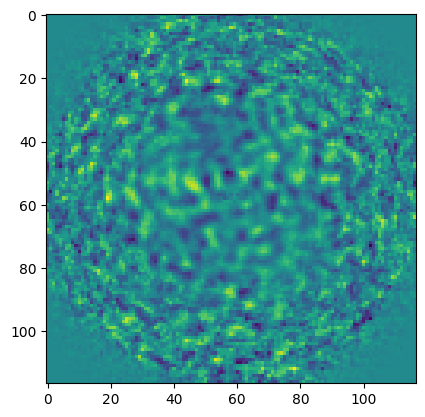

In [51]:
plt.imshow(residual.detach().numpy()[0])

# Compute the residual with unbiased normalizations

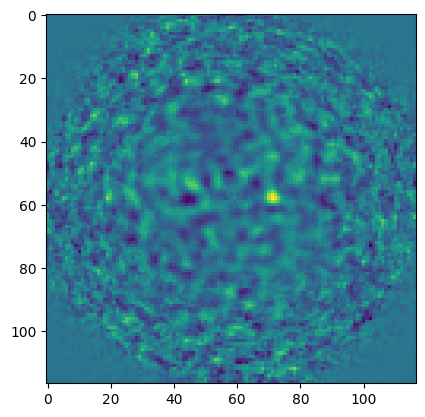

In [52]:
# currect mean
data_no_planet = torch.from_numpy(science_stacked).float()

x_norm = s4_model.science_data - torch.mean(data_no_planet, axis=0)
x_norm /= torch.std(x_norm, axis=0)
science_norm_flatten = x_norm.view(x_norm.shape[0], -1)

# compute the residual
s4_model.noise_model.compute_betas()
noise_estimate = s4_model.noise_model(science_norm_flatten)

# compute the residual sequence and rotate it
residual_sequence = science_norm_flatten - noise_estimate
residual_sequence = residual_sequence.view(
    residual_sequence.shape[0],
    1,
    s4_model.data_image_size,
    s4_model.data_image_size)

rotated_frames = s4_model.rotation_model(
    residual_sequence,
    parang_idx=torch.arange(len(residual_sequence)))

# compute the residual
residual = torch.mean(rotated_frames, axis=0)
plt.imshow(residual.detach().numpy()[0])

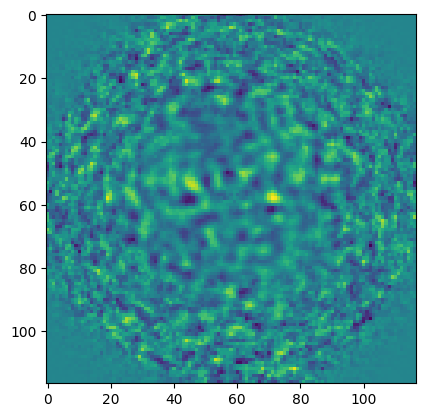

In [53]:
# correct std
data_no_planet = torch.from_numpy(science_stacked).float()

x_norm = s4_model.science_data - torch.mean(s4_model.science_data, axis=0)
x_norm /= torch.std(data_no_planet, axis=0)
science_norm_flatten = x_norm.view(x_norm.shape[0], -1)

# compute the residual
s4_model.noise_model.compute_betas()
noise_estimate = s4_model.noise_model(science_norm_flatten)

# compute the residual sequence and rotate it
residual_sequence = science_norm_flatten - noise_estimate
residual_sequence = residual_sequence.view(
    residual_sequence.shape[0],
    1,
    s4_model.data_image_size,
    s4_model.data_image_size)

rotated_frames = s4_model.rotation_model(
    residual_sequence,
    parang_idx=torch.arange(len(residual_sequence)))

# compute the residual
residual = torch.mean(rotated_frames, axis=0)
plt.imshow(residual.detach().numpy()[0])

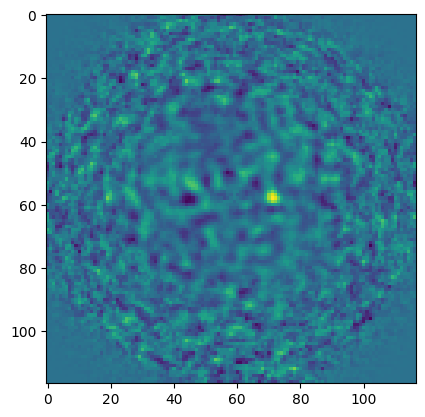

In [54]:
# correct std and mean
data_no_planet = torch.from_numpy(science_stacked).float()

x_norm = s4_model.science_data - torch.mean(data_no_planet, axis=0)
x_norm /= torch.std(data_no_planet, axis=0)
science_norm_flatten = x_norm.view(x_norm.shape[0], -1)

# compute the residual
s4_model.noise_model.compute_betas()
noise_estimate = s4_model.noise_model(science_norm_flatten)

# compute the residual sequence and rotate it
residual_sequence = science_norm_flatten - noise_estimate
residual_sequence = residual_sequence.view(
    residual_sequence.shape[0],
    1,
    s4_model.data_image_size,
    s4_model.data_image_size)

rotated_frames = s4_model.rotation_model(
    residual_sequence,
    parang_idx=torch.arange(len(residual_sequence)))

# compute the residual
residual = torch.mean(rotated_frames, axis=0)
plt.imshow(residual.detach().numpy()[0])